In [1]:
!pip install -q kaggle

from google.colab import files
files.upload()

!mkdir ~/.kaggle/
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

Saving kaggle.json to kaggle.json


In [2]:
import os
import kaggle
import random
import zipfile
from glob import glob
from PIL import Image
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from breast_cancer_dataset import BreastCancerDataset

import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, Dataset

In [3]:
# Define dataset paths
DATA_DIR = "BreastHistopathology"
KAGGLE_DATASET = "paultimothymooney/breast-histopathology-images"
ZIP_FILE = "breast-histopathology-images.zip"

def ensure_dataset():
    """Ensures dataset is downloaded and extracted properly."""
    # 1️⃣ Create directory if it doesn't exist
    if not os.path.exists(DATA_DIR):
        os.makedirs(DATA_DIR)
        print(f"📁 Created dataset directory: {DATA_DIR}")

    # 2️⃣ Check if dataset is already extracted
    num_images = len(glob(os.path.join(DATA_DIR, "**", "*.png"), recursive=True))
    if num_images > 0:
        print(f"✅ Dataset already available with {num_images} images.")
        return  # Skip download

    # 3️⃣ Download dataset from Kaggle if not present
    if not os.path.exists(ZIP_FILE):
        print("📥 Downloading dataset from Kaggle...")
        kaggle.api.dataset_download_files(KAGGLE_DATASET, path="./", unzip=False)
        print("✅ Download complete!")

    # 4️⃣ Extract dataset
    print("📂 Extracting dataset...")
    with zipfile.ZipFile(ZIP_FILE, "r") as zip_ref:
        zip_ref.extractall(DATA_DIR)
    print("✅ Extraction complete!")

    # 5️⃣ Verify extraction
    num_images = len(glob(os.path.join(DATA_DIR, "**", "*.png"), recursive=True))
    if num_images == 0:
        raise RuntimeError(f"❌ Extraction failed. No images found in {DATA_DIR}.")

    print(f"✅ Dataset ready with {num_images} images.")

# Ensure dataset is downloaded & extracted
ensure_dataset()

# ✅ Get all image paths
all_image_paths = glob(os.path.join(DATA_DIR, "**", "*.png"), recursive=True)
print(f"✅ Total images found: {len(all_image_paths)}")

# ✅ Filter non-cancerous images (class '0') for training
normal_paths = glob(os.path.join(DATA_DIR, "**", "0", "*.png"), recursive=True)  # Non-cancerous images
cancerous_paths = glob(os.path.join(DATA_DIR, "**", "1", "*.png"), recursive=True)  # Cancerous images

print(f"🔹 Non-cancerous images (for training): {len(normal_paths)}")
print(f"🔹 Cancerous images (for testing): {len(cancerous_paths)}")

# ✅ Now use `normal_paths` for training & validation, and `cancerous_paths` for testing

📁 Created dataset directory: BreastHistopathology
📥 Downloading dataset from Kaggle...
Dataset URL: https://www.kaggle.com/datasets/paultimothymooney/breast-histopathology-images
✅ Download complete!
📂 Extracting dataset...
✅ Extraction complete!
✅ Dataset ready with 555048 images.
✅ Total images found: 555048
🔹 Non-cancerous images (for training): 397476
🔹 Cancerous images (for testing): 157572


In [53]:
# Get all image paths
all_image_paths = glob(os.path.join(DATA_DIR, "**", "*.png"), recursive=True)
print(f"✅ Total images found: {len(all_image_paths)}")

# Split into Train (80%), Validation (10%), Test (10%)
train_paths, test_paths = train_test_split(all_image_paths, test_size=0.2, random_state=42)
val_paths, test_paths = train_test_split(test_paths, test_size=0.5, random_state=42)

print(f"🔹 Train set: {len(train_paths)} images")
print(f"🔹 Validation set: {len(val_paths)} images")
print(f"🔹 Test set: {len(test_paths)} images")

# Define image preprocessing (resize, normalize)
transform = transforms.Compose([
    transforms.Resize((64, 64), interpolation=transforms.InterpolationMode.BICUBIC),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])  # Normalize to [-1, 1]
])

# Create PyTorch Datasets
train_dataset = BreastCancerDataset(train_paths, transform=transform)
val_dataset = BreastCancerDataset(val_paths, transform=transform)
test_dataset = BreastCancerDataset(test_paths, transform=transform)

# Create DataLoaders
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True, num_workers=4)
val_loader = DataLoader(val_dataset, batch_size=64, shuffle=False, num_workers=4)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False, num_workers=4)

print("✅ DataLoaders ready!")

✅ Total images found: 555048
🔹 Train set: 444038 images
🔹 Validation set: 55505 images
🔹 Test set: 55505 images
✅ DataLoaders ready!


In [54]:
# Define fraction to use for quick testing
fraction = 0.02 # Use only 1% of the dataset

# Reduce dataset size while maintaining the same split ratio
def reduce_dataset_size(image_paths, fraction):
    new_size = max(1, int(len(image_paths) * fraction))  # Ensure at least 1 image
    return random.sample(image_paths, new_size)

# Reduce train, val, and test sets
train_paths = reduce_dataset_size(train_paths, fraction)
val_paths = reduce_dataset_size(val_paths, fraction)
test_paths = reduce_dataset_size(test_paths, fraction)

print(f"🔹 New Train set: {len(train_paths)} images")
print(f"🔹 New Validation set: {len(val_paths)} images")
print(f"🔹 New Test set: {len(test_paths)} images")

# Create PyTorch Datasets with reduced data
train_dataset = BreastCancerDataset(train_paths, transform=transform)
val_dataset = BreastCancerDataset(val_paths, transform=transform)
test_dataset = BreastCancerDataset(test_paths, transform=transform)

# Create DataLoaders with reduced dataset
train_loader = DataLoader(train_dataset, batch_size=100, shuffle=True, num_workers=4)
val_loader = DataLoader(val_dataset, batch_size=100, shuffle=False, num_workers=4)
test_loader = DataLoader(test_dataset, batch_size=100, shuffle=False, num_workers=4)

print("✅ Reduced DataLoaders ready for quick testing!")

🔹 New Train set: 8880 images
🔹 New Validation set: 1110 images
🔹 New Test set: 1110 images
✅ Reduced DataLoaders ready for quick testing!


In [55]:
class ConvVAE(nn.Module):
    def __init__(self, latent_dim=64):
        super(ConvVAE, self).__init__()

        # Encoder (Convolutional Feature Extractor)
        self.encoder = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=3, stride=2, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),

            nn.Conv2d(32, 64, kernel_size=3, stride=2, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),

            nn.Conv2d(64, 128, kernel_size=3, stride=2, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),

            nn.Conv2d(128, 256, kernel_size=3, stride=2, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU()
        )

        self.fc_mu = nn.Linear(256*4*4, latent_dim)
        self.fc_logvar = nn.Linear(256*4*4, latent_dim)
        self.fc_z = nn.Linear(latent_dim, 256*4*4)

        # Decoder (Transposed Conv for Image Reconstruction)
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(256, 128, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),

            nn.ConvTranspose2d(128, 64, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),

            nn.ConvTranspose2d(64, 32, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),

            nn.ConvTranspose2d(32, 3, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.Tanh()  # Output in range [-1,1]
        )

    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mu + eps * std

    def forward(self, x):
        x = self.encoder(x)
        x = torch.flatten(x, start_dim=1)
        mu, logvar = self.fc_mu(x), self.fc_logvar(x)
        z = self.reparameterize(mu, logvar)
        z = self.fc_z(z).view(-1, 256, 4, 4)
        recon_x = self.decoder(z)
        return recon_x, mu, logvar

In [56]:
# Load a saved model checkpoint
def load_trained_vae(model_path, latent_dim=64, device='cpu'):
    model = ConvVAE(latent_dim=latent_dim).to(device)
    model.load_state_dict(torch.load(model_path, map_location=device))
    model.eval()
    print(f"Model loaded from {model_path}")
    return model

# Preliminary model evaluation based on sum total reconstruction loss
def evaluate_vae(model, dataloader, device='cpu'):
    model.eval()
    model.to(device)

    total_recon_loss = 0
    num_samples = 0

    with torch.no_grad():
        for images, _ in dataloader:
            images = images.to(device)
            recon_images, _, _ = model(images)

            recon_loss = F.mse_loss(recon_images, images, reduction='sum')
            total_recon_loss += recon_loss.item()
            num_samples += images.size(0)

    avg_recon_loss = total_recon_loss / num_samples
    print(f"Average Reconstruction Loss: {avg_recon_loss:.4f}")

    return avg_recon_loss

# Visualize Images (Expectation vs. Reconstruction)
def visualize_reconstruction(model, dataloader, action, device='cpu', num_images=10):
    model.eval()
    model.to(device)

    images, _ = next(iter(dataloader))
    images = images.to(device)
    indices = torch.randperm(images.size(0))[:num_images]
    images = images[indices]

    with torch.no_grad():
        recon_images, _, _ = model(images)

    images = (images + 1) / 2
    recon_images = (recon_images + 1) / 2

    fig, axes = plt.subplots(2, num_images, figsize=(15, 4))

    for i in range(num_images):
        axes[0, i].imshow(images[i].permute(1, 2, 0).cpu().numpy())
        axes[0, i].axis("off")
        axes[1, i].imshow(recon_images[i].permute(1, 2, 0).cpu().numpy())
        axes[1, i].axis("off")

    axes[0, 0].set_title("Original Images")
    axes[1, 0].set_title("Reconstructed Images")

    plot_name = f"{action}_sample_results.png"
    plt.savefig(plot_name)
    plt.show()

In [57]:
# Train model
def train_vae(model, dataloader, num_epochs=100, device='cpu', save_path="vae_colab_64x64_64L.pth"):
    model.to(device)
    optimizer = torch.optim.AdamW(model.parameters(), lr=1e-3, weight_decay=1e-4)

    train_losses = []  # Store total loss
    recon_losses = []  # Store reconstruction loss
    kl_losses = []  # Store KL divergence loss

    for epoch in range(num_epochs):
        model.train()
        total_loss = 0
        total_recon_loss = 0
        total_kl_loss = 0

        print(f"Epoch {epoch+1}/{num_epochs}:", end=" ")

        # Raw KL-div contribution to total loss
        kl_weight = 1.0
        # [Optional] KL Annealing: Linearly increase from 0.01 → 1.0 over training
        # kl_weight = min(1.0, 0.01 + (epoch / num_epochs))

        for images, _ in dataloader:
            print(".", end="")
            images = images.to(device)

            optimizer.zero_grad()
            recon_x, mu, logvar = model(images)

            # Compute Losses
            recon_loss = F.mse_loss(recon_x, images, reduction='sum')
            kl_div = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())

            # Total loss is weighted sum of reconstruction loss and KL divergence
            loss = recon_loss + kl_weight * kl_div

            # Backpropagation
            loss.backward()
            optimizer.step()

            total_loss += loss.item()
            total_recon_loss += recon_loss.item()
            total_kl_loss += kl_div.item()

        avg_loss = total_loss / len(dataloader.dataset)
        avg_recon_loss = total_recon_loss / len(dataloader.dataset)
        avg_kl_loss = total_kl_loss / len(dataloader.dataset)

        train_losses.append(avg_loss)
        recon_losses.append(avg_recon_loss)
        kl_losses.append(avg_kl_loss)

        print(f" | Loss: {avg_loss:.4f} (Recon: {avg_recon_loss:.4f}, KL: {avg_kl_loss:.4f}, KL weight: {kl_weight:.3f})")

        # Save model every 10 epochs
        if (epoch + 1) % 10 == 0:
            torch.save(model.state_dict(), save_path)
            print(f"Model checkpoint saved at epoch {epoch+1}")

    # Save final model
    torch.save(model.state_dict(), save_path)
    print("Training complete! Model saved.")

    # Plot Training Losses
    plt.figure(figsize=(10, 5))
    plt.plot(range(2, num_epochs + 1), train_losses[1:], label="Total Loss", marker='o', linestyle='-')
    plt.plot(range(2, num_epochs + 1), recon_losses[1:], label="Reconstruction Loss", marker='o', linestyle='--')
    plt.plot(range(2, num_epochs + 1), kl_losses[1:], label="KL Divergence Loss", marker='o', linestyle=':')
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.title("VAE Training Loss Breakdown")
    plt.legend()
    plt.grid()
    plt.savefig("Training_Loss_Breakdown.png")
    plt.show()

    return train_losses, recon_losses, kl_losses

Epoch 1/50: ......................................................................................... | Loss: 1076.7769 (Recon: 1017.4893, KL: 59.2876, KL weight: 1.000)
Epoch 2/50: ......................................................................................... | Loss: 614.1635 (Recon: 565.4496, KL: 48.7139, KL weight: 1.000)
Epoch 3/50: ......................................................................................... | Loss: 562.4453 (Recon: 511.3425, KL: 51.1027, KL weight: 1.000)
Epoch 4/50: ......................................................................................... | Loss: 522.2176 (Recon: 467.9746, KL: 54.2430, KL weight: 1.000)
Epoch 5/50: ......................................................................................... | Loss: 502.9090 (Recon: 447.1607, KL: 55.7484, KL weight: 1.000)
Epoch 6/50: ......................................................................................... | Loss: 489.2680 (Recon: 432.6748, KL: 56.5932, KL weigh

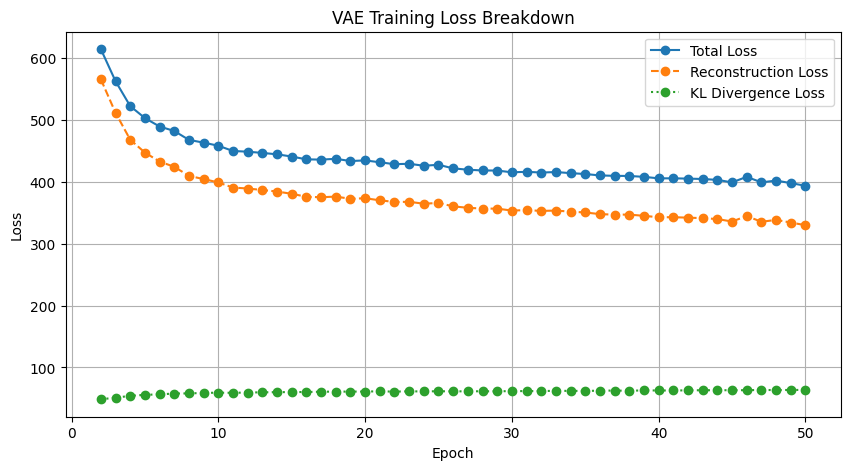

In [58]:
# Select the device (GPU or CPU)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Model Parameters
image_shape = (64, 64)
epochs = 50
latent_dim = 64

# Model name
model_name = f"Vanilla_ConvVae_{image_shape[0]}x{image_shape[1]}_{latent_dim}L_{epochs}e.pth"

# Define the model
vae_model = ConvVAE(latent_dim=latent_dim)
#vae_model = load_trained_vae(model_name, latent_dim=latent_dim)

# Train the model
train_losses = train_vae(vae_model, train_loader, num_epochs=epochs, device=device, save_path=model_name)



---



In [59]:
# [Optional] Load VAE model
# vae_model = load_trained_vae("vae_model_50x50.pth")

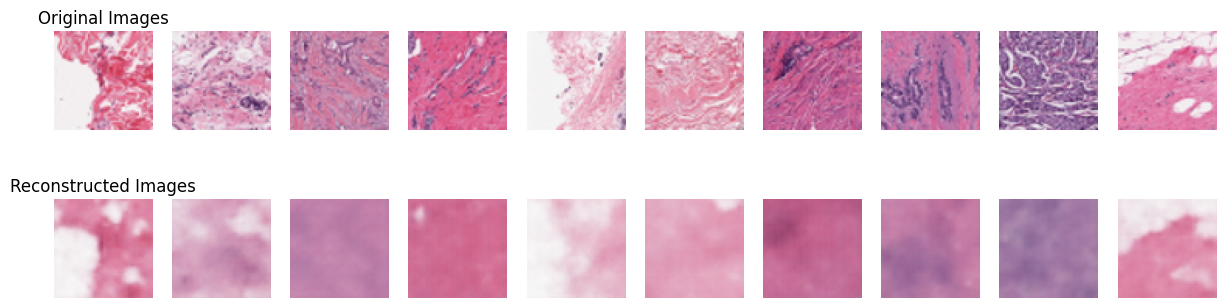

In [60]:
# Visualize reconstruction on training subset
visualize_reconstruction(vae_model, train_loader, 'training')

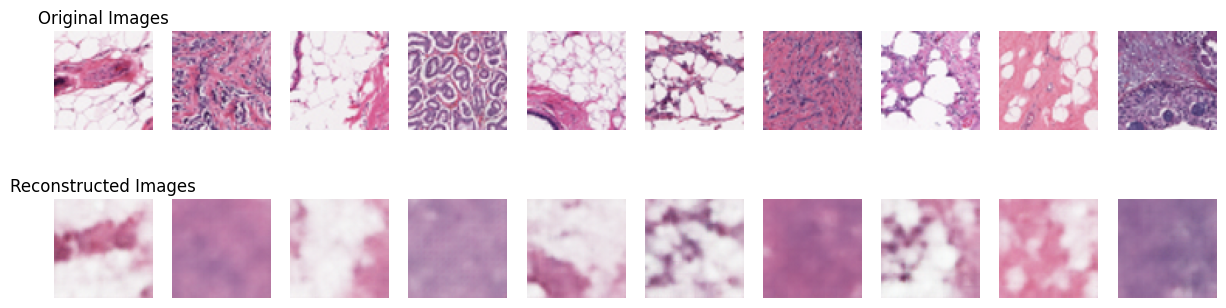

In [61]:
# Visualize reconstruction on validation subset
visualize_reconstruction(vae_model, val_loader, 'validation')

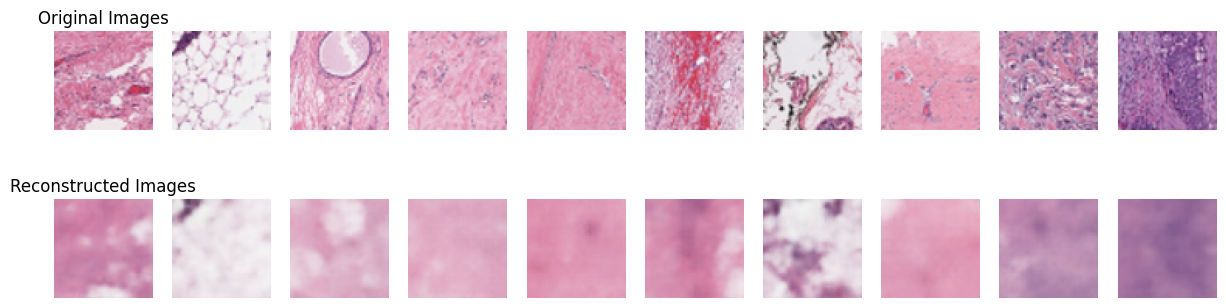

In [62]:
# Visualize reconstruction on testing subset
visualize_reconstruction(vae_model, test_loader, 'testing')

In [63]:
# Evaluate model performance on training subset
# evaluate_vae(vae_model, train_loader)

# Evaluate model performance on validation subset
# evaluate_vae(vae_model, val_loader)

# Evaluate model performance on testing subset
evaluate_vae(vae_model, test_loader)

Average Reconstruction Loss: 394.7860


394.7860023842202


---
